In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

### Dataset:

Markelle Kelly, Rachel Longjohn, Kolby Nottingham,
The UCI Machine Learning Repository, https://archive.ics.uci.edu

Source: Bock,R.. (2007). MAGIC Gamma Telescope. UCI Machine Learning Repository. https://doi.org/10.24432/C52C8B.

In [2]:
# Data ingest
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("../datasets/magic04.data", names=cols)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [3]:
# cols are features that will be passed to the model to help us predict the label (class)
df["class"].unique()


array(['g', 'h'], dtype=object)

In [4]:
# Convert: g -> 1, h -> 0 so machine handles numbers and not characters/strings
df["class"] = (df["class"] == "g").astype(int)

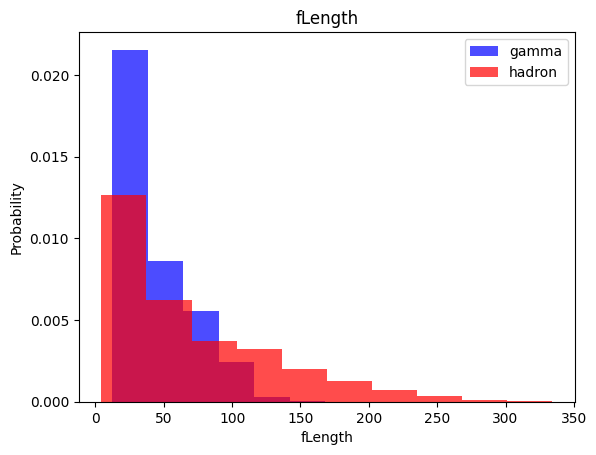

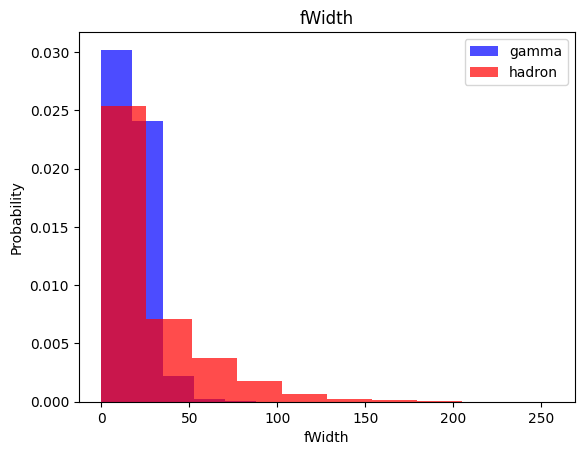

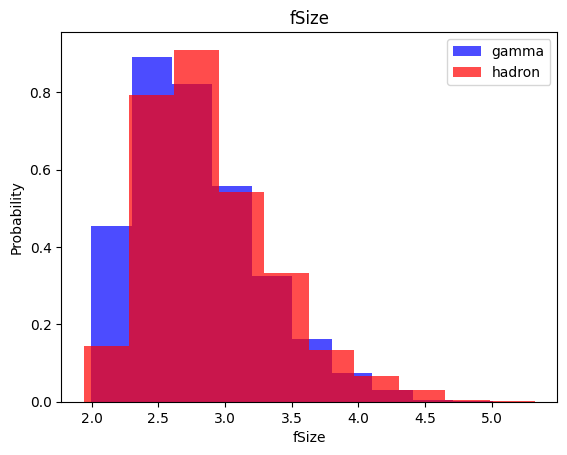

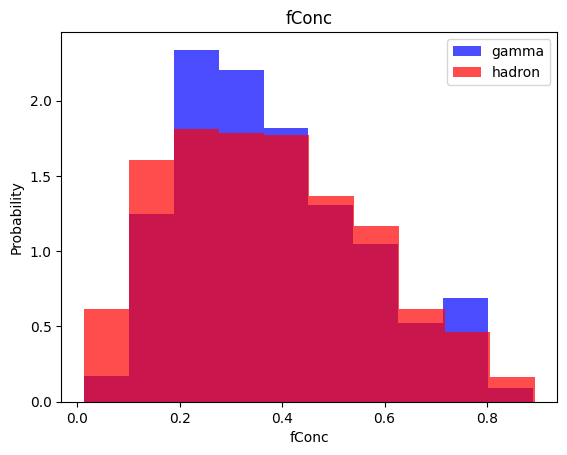

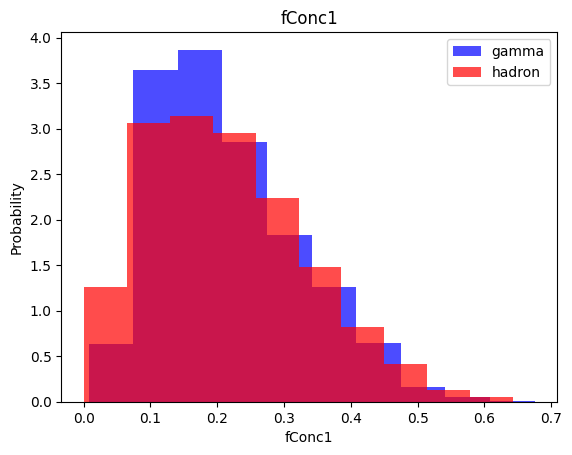

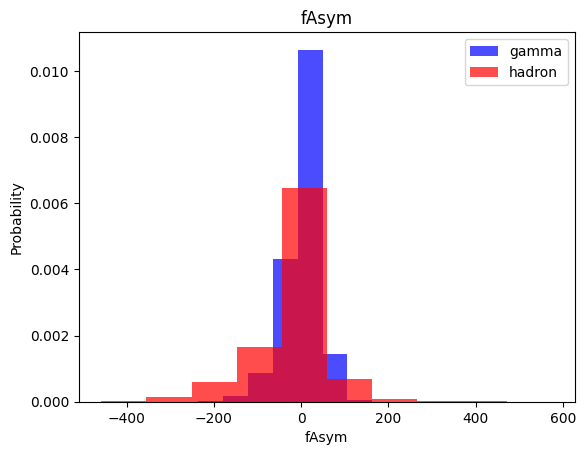

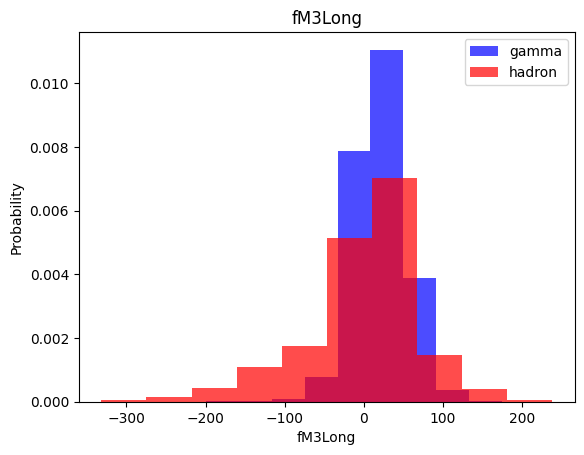

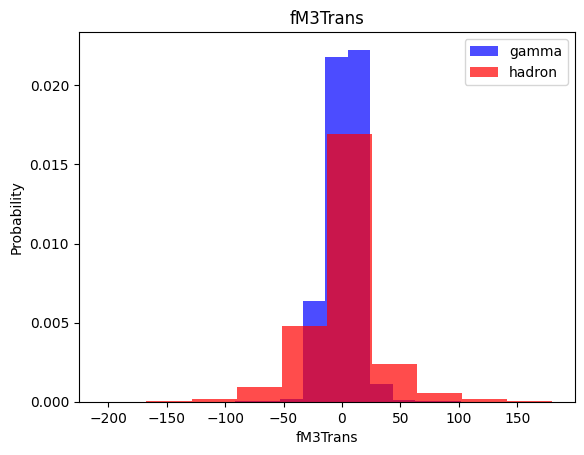

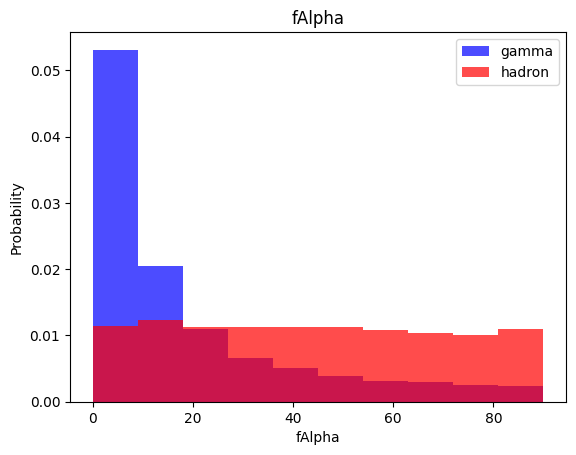

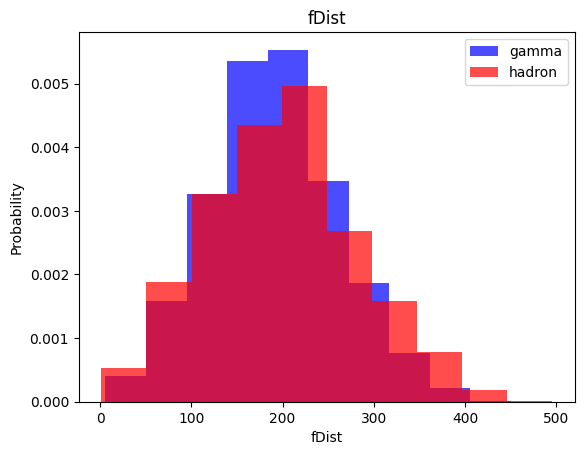

In [5]:
# Each chart represents a different feature
# Use these visuals to discern correlations and get a good idea of what feature affects the final output
for label in df.columns[:-1]:
    # alpha: for transparency
    # density: for normalizing graph, distributing based on how many samples there are
    plt.hist(df[df["class"] == 1][label], color="blue", label="gamma", alpha=0.7, density=True) # gammas
    plt.hist(df[df["class"] == 0][label], color="red", label="hadron", alpha=0.7, density=True) # hadrons
    plt.title(label)
    plt.ylabel("Probability") # Because density=True, it is now probability
    plt.xlabel(label)
    plt.legend()
    plt.show()

## Some observations:

**fLength:** if smaller, could more likely be gamma

**fAsym:** if more asymmetry, more likely to be hadron

**fAlpha:** if smaller, more likely gamma, hadrons are evenly distributed

# Train, Validation, Test Datasets

In [6]:
# Train: 60%, Validation: 20%, Test: 20%
# df.sample(frac=1) to get all samples of df
# np.split() to split dataset with partitions at 60 and 80
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])


D:\Python_Projects\MachineLearning\TensorFlowTutortial\venv311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def scale_dataset(dataframe, oversample=False):
    """Because random sampling of values can have outliers that might affect the results, we must scale the data

    dataframe: dataframe to scale
    oversample: whether to oversample the given data or not, default False

    Returns:
        Scaled dataset (& oversampled if True),
        X part,
        y part
    """
    X = dataframe[dataframe.columns[:-1]].values # 2D
    y = dataframe[dataframe.columns[-1]].values # 1D

    scaler = StandardScaler()
    X = scaler.fit_transform(X) # Fit standard scaler to X and transform all those values (2D)

    if oversample:
        # Oversample the class with the lesser occurrence until they match in size
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    # Join the arrays horizontally, must be same shape (in this case, 2D)
    # Reshape y to 2D, -1 tells numpy to infer the length, you could also do len(y)
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [8]:
# Significantly more samples for hadrons than gammas,
# we must oversample the hadrons for the TRAINING dataset so that these 2 sample sizes match closer
# otherwise there can be issues in the training
print("gammas:", len(train[train["class"] == 1])) # gammas
print("hadrons:", len(train[train["class"] == 0])) # hadrons

gammas: 7398
hadrons: 4014


In [9]:
# Must oversample training dataset
# Validation and test datasets need not be oversampled as we are trying to verify that our model can handle data it hasn't seen before
# Can you trust the model to handle unbalanced data?
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [10]:
# Check to see if the different class samples equal for the training dataset
print("gamma:", sum(y_train == 0))
print("hadron:", sum(y_train == 1))

gamma: 7398
hadron: 7398


# Model: k-Nearest Neighbor (KNN)

**accuracy:** right predictions/total samples

**precision:** true positives/(true positives + false positives); out of all the LABELED positives, how many are truly positive?

**recall:** true positives/(true positives + false negatives); out of the TOTAL (actual) positives. how many did we predict truly positive?

**f1 score:** combination of both precision and recall (most likely an avg of the 2)

https://en.wikipedia.org/wiki/Precision_and_recall

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train) # Train (fit) model

KNeighborsClassifier()

In [13]:
# Make predictions on the test dataset
y_pred = knn_model.predict(X_test)

In [14]:
print(y_pred) # Prediction
print(y_test) # Actual

[1 0 1 ... 1 1 1]
[1 0 1 ... 1 1 1]


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1321
           1       0.85      0.86      0.86      2483

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



# Model: Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [18]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.41      0.51      1321
           1       0.74      0.89      0.81      2483

    accuracy                           0.73      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



# Model: Log(istic) Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
# penalty: l2 penalizes outliers
# If production model, you would customize the parameters that best suits your validation data
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [21]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1321
           1       0.84      0.81      0.83      2483

    accuracy                           0.78      3804
   macro avg       0.76      0.76      0.76      3804
weighted avg       0.78      0.78      0.78      3804



# Model: Support Vector Machines (SVM)

In [22]:
from sklearn.svm import SVC

In [23]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [24]:
# If production model, you would customize the parameters that best suits your validation data
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1321
           1       0.89      0.89      0.89      2483

    accuracy                           0.86      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.86      0.86      0.86      3804



# Neural Network (TensorFlow)

TensorFlow keeps track of history so you can plot it

**Epoch:** training cycle(s)

**loss:** loss; **val_loss:** validation loss

In [25]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_history(history):
    """Combination of the above 2 functions as side-by-side charts
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary crossentropy")
    ax1.grid(True)

    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

**A lot of machine learning is just what do we set these parameters to in order to get the best results?**

In [26]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs, verbose=0):
    """Creates the neural network, compiles the model, and trains the model

    X_train: training data (X part)
    y_train: training data (y part)
    num_nodes: number of nodes per layer
    dropout_prob: probability of turning off random nodes for each layer
    lr: learning rate
    batch_size: batch size
    epochs: training cycles
    verbose: whether or not to display the training iterations

    Returns:
        neural network model,
        training history
    """
    # layers: layer the layers on top of each other as a model
    nn_model = tf.keras.Sequential([
        # input_shape: shape of input layer (features)
        tf.keras.layers.Dense(num_nodes, activation="relu", input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        # signmoid because we are essentially projecting our predictions to be 0 or 1 (just like in logistic regression)
        # It will help us round to 0 or 1 to classify
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    # adam -> learning rate = 0.001: the alpha in the function in my notes
    # loss: formula for loss calculation
    # metrics: extra tags to add (for charts maybe)
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=["accuracy"])

    # verbose: whether or not to print the training iterations
    # validation_split: the fraction of the training data to be used as the validation data
    # validation_data: the validation dataset that you've set aside manually, this overrides validation_split
    #
    # TensorFlow allows you to split the training data into a validation portion that is to be used DURING the training
    history = nn_model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=verbose
    )

    return nn_model, history

100 epochs, 16 nodes, 0 dropout, 0.1 lr, 32 batch size


D:\Python_Projects\MachineLearning\TensorFlowTutortial\venv311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


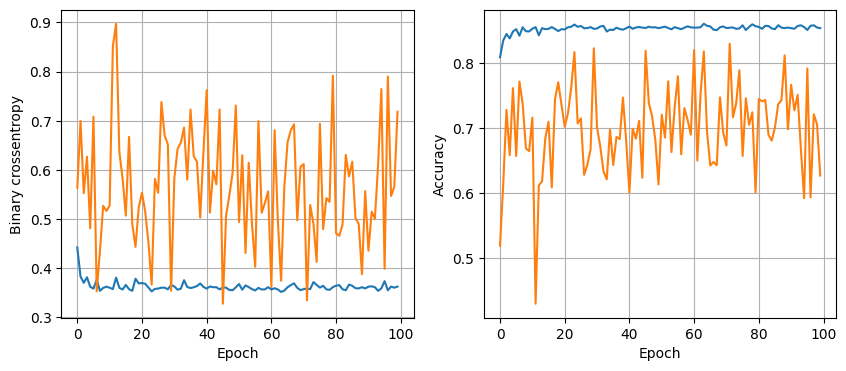

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.8402 - loss: 0.3834
100 epochs, 16 nodes, 0 dropout, 0.1 lr, 64 batch size


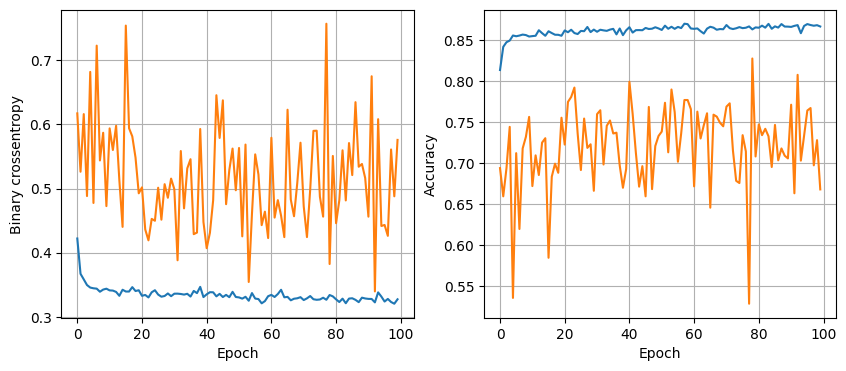

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.8480 - loss: 0.3521
100 epochs, 16 nodes, 0 dropout, 0.1 lr, 128 batch size


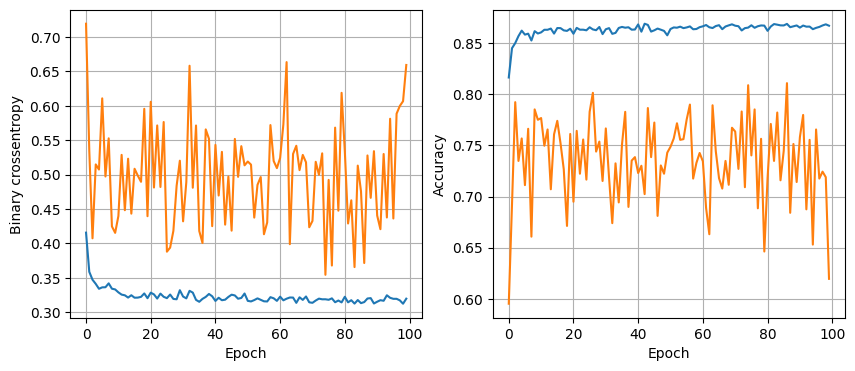

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8464 - loss: 0.3580
100 epochs, 16 nodes, 0 dropout, 0.005 lr, 32 batch size


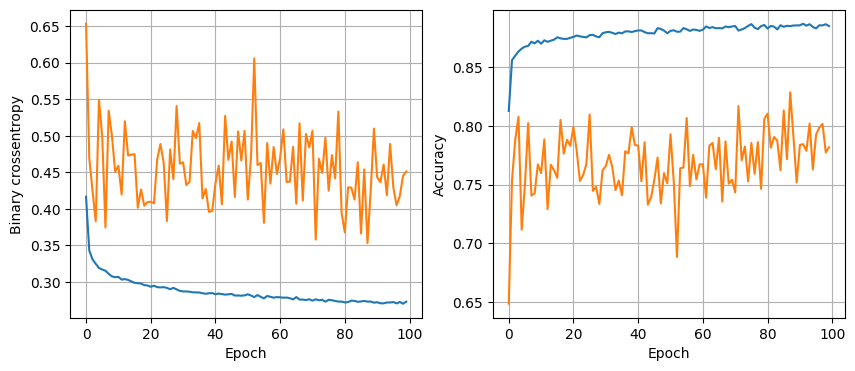

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.8514 - loss: 0.3340
100 epochs, 16 nodes, 0 dropout, 0.005 lr, 64 batch size


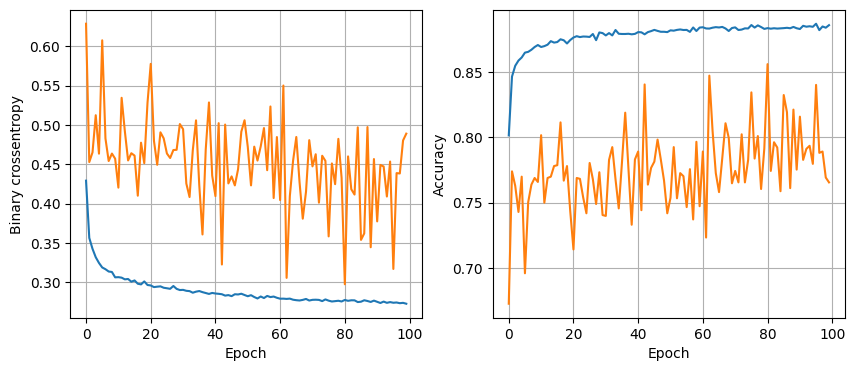

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.8596 - loss: 0.3355
100 epochs, 16 nodes, 0 dropout, 0.005 lr, 128 batch size


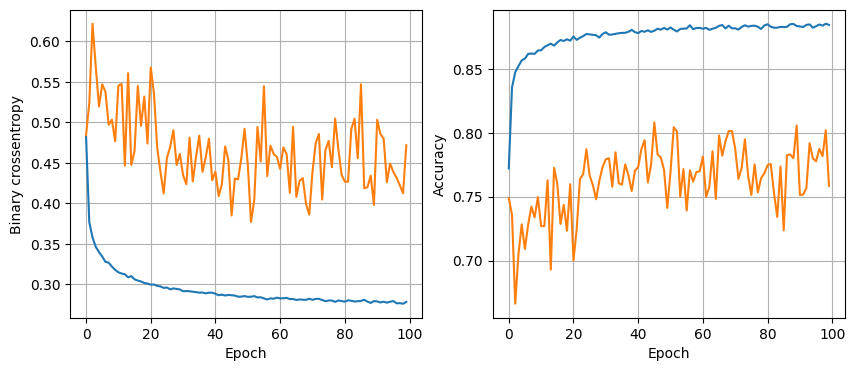

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.8584 - loss: 0.3361
100 epochs, 16 nodes, 0 dropout, 0.001 lr, 32 batch size


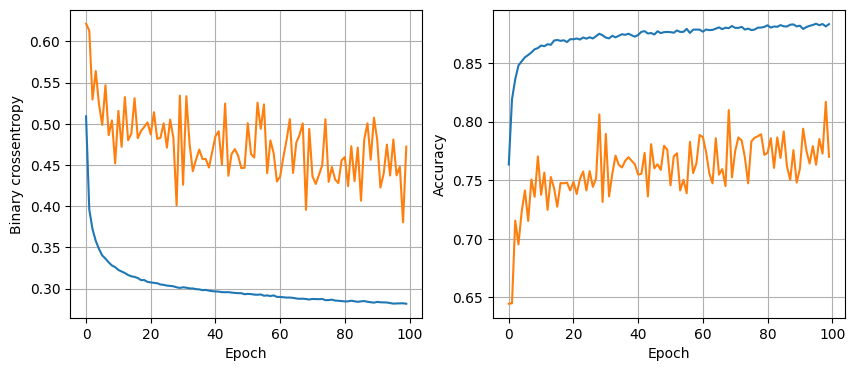

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.8641 - loss: 0.3272
100 epochs, 16 nodes, 0 dropout, 0.001 lr, 64 batch size


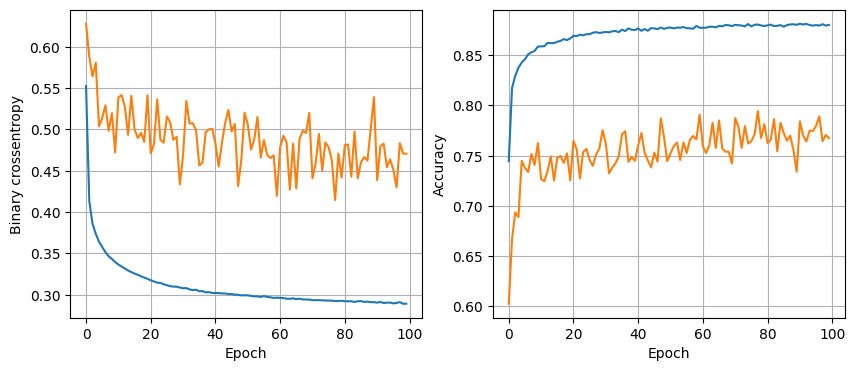

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.8566 - loss: 0.3365
100 epochs, 16 nodes, 0 dropout, 0.001 lr, 128 batch size


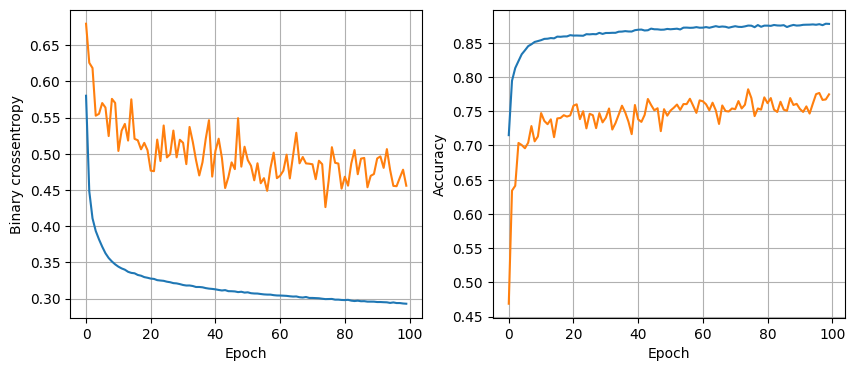

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.8532 - loss: 0.3364
100 epochs, 16 nodes, 0.2 dropout, 0.1 lr, 32 batch size


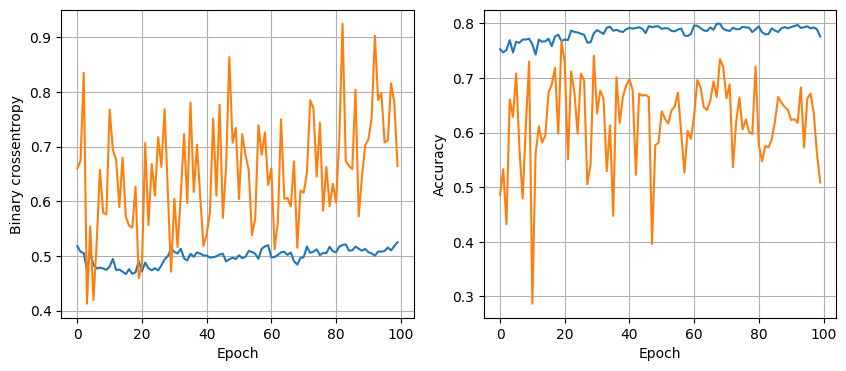

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.8174 - loss: 0.4833
100 epochs, 16 nodes, 0.2 dropout, 0.1 lr, 64 batch size


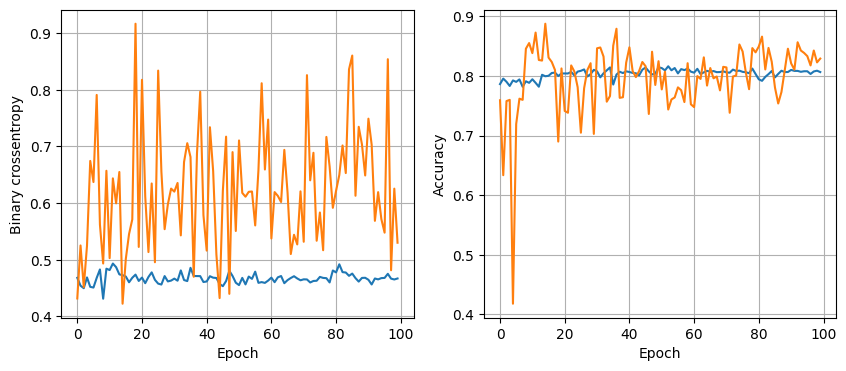

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - accuracy: 0.8068 - loss: 0.4664
100 epochs, 16 nodes, 0.2 dropout, 0.1 lr, 128 batch size


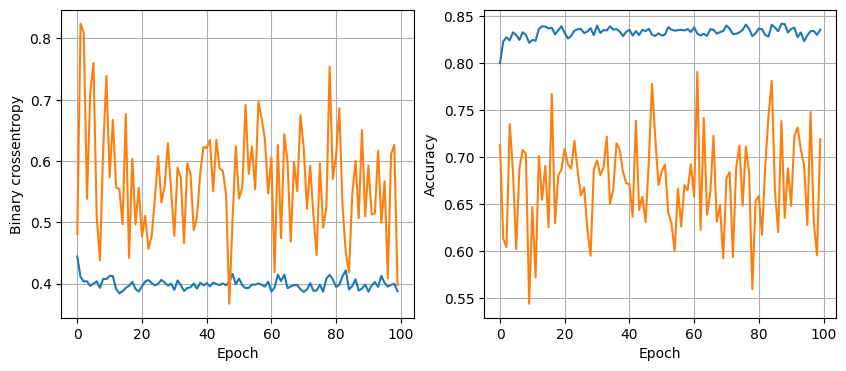

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.8539 - loss: 0.4660
100 epochs, 16 nodes, 0.2 dropout, 0.005 lr, 32 batch size


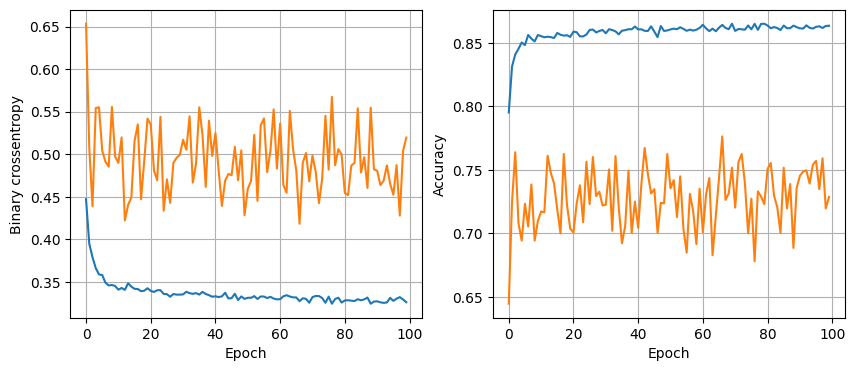

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - accuracy: 0.8571 - loss: 0.3340
100 epochs, 16 nodes, 0.2 dropout, 0.005 lr, 64 batch size


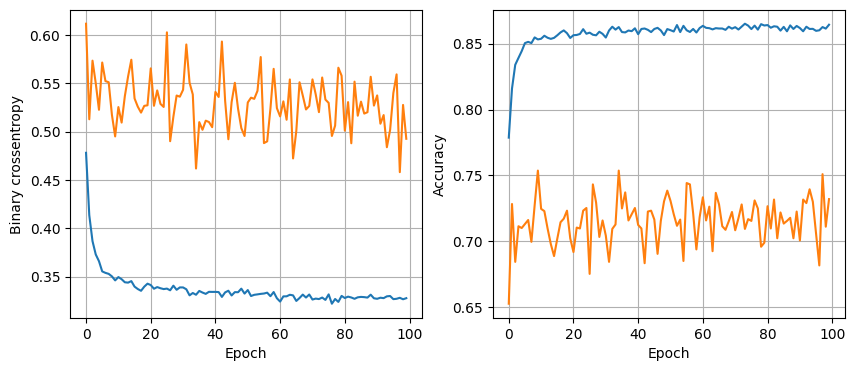

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.8534 - loss: 0.3331
100 epochs, 16 nodes, 0.2 dropout, 0.005 lr, 128 batch size


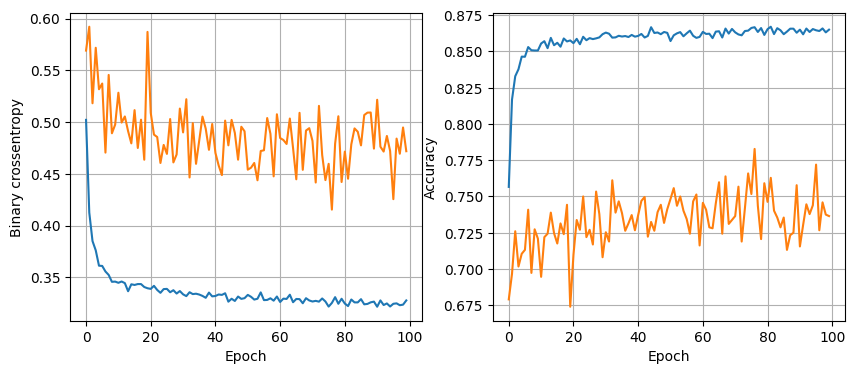

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.8609 - loss: 0.3307
100 epochs, 16 nodes, 0.2 dropout, 0.001 lr, 32 batch size


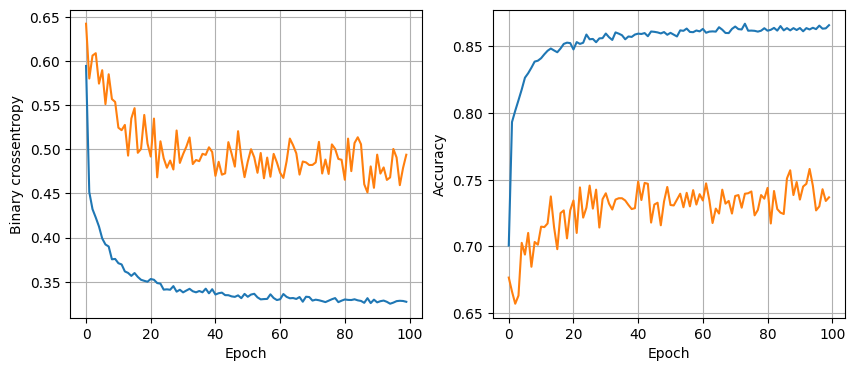

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.8621 - loss: 0.3304
100 epochs, 16 nodes, 0.2 dropout, 0.001 lr, 64 batch size


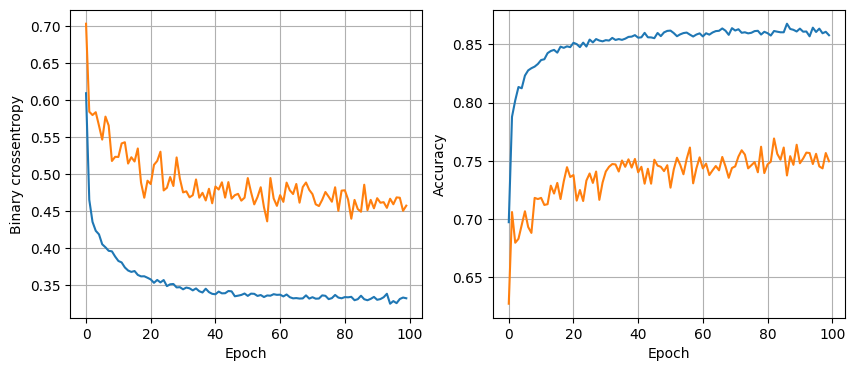

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.8561 - loss: 0.3321
100 epochs, 16 nodes, 0.2 dropout, 0.001 lr, 128 batch size


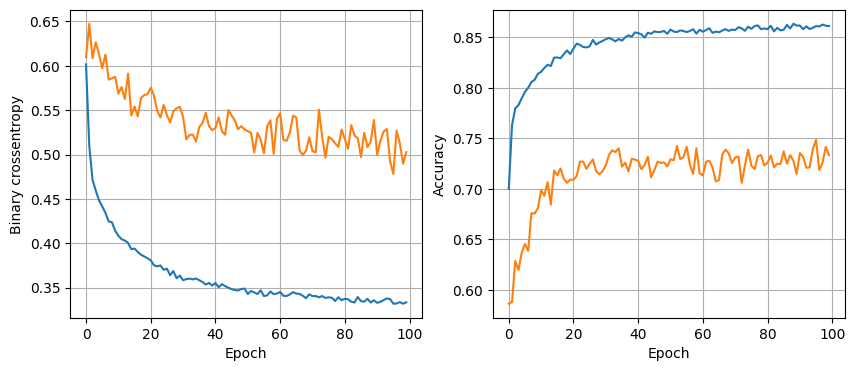

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.8542 - loss: 0.3327
100 epochs, 32 nodes, 0 dropout, 0.1 lr, 32 batch size


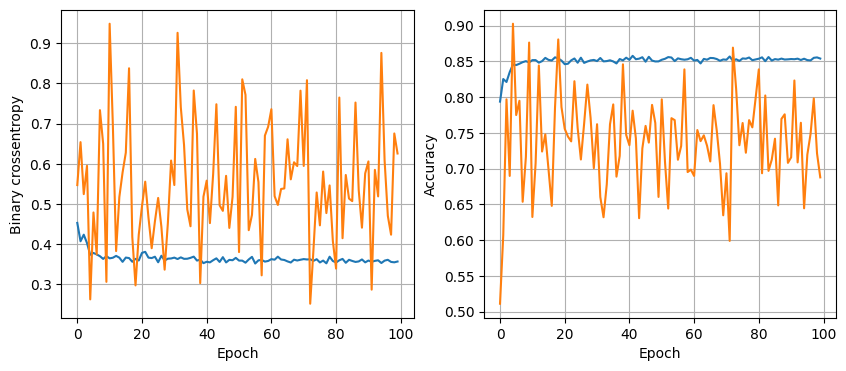

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.8200 - loss: 0.4290
100 epochs, 32 nodes, 0 dropout, 0.1 lr, 64 batch size


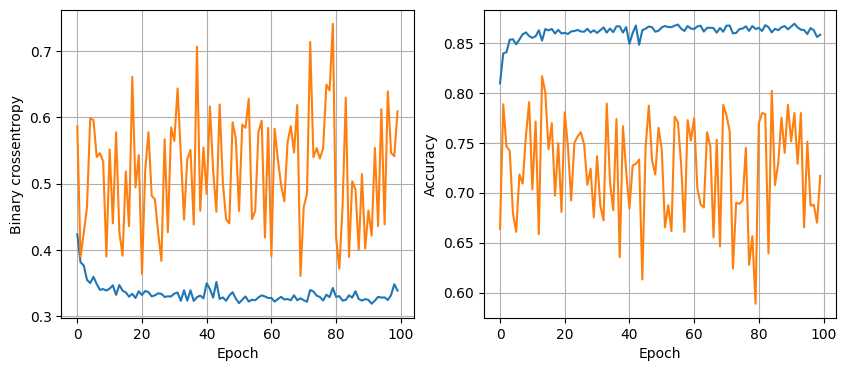

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.8541 - loss: 0.3996
100 epochs, 32 nodes, 0 dropout, 0.1 lr, 128 batch size


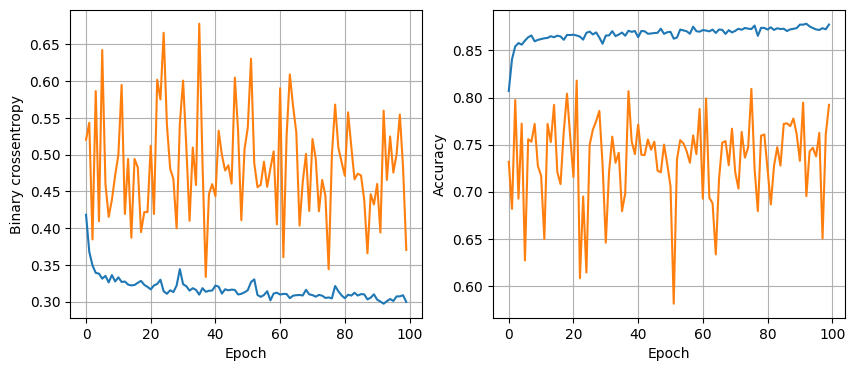

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8541 - loss: 0.3487
100 epochs, 32 nodes, 0 dropout, 0.005 lr, 32 batch size


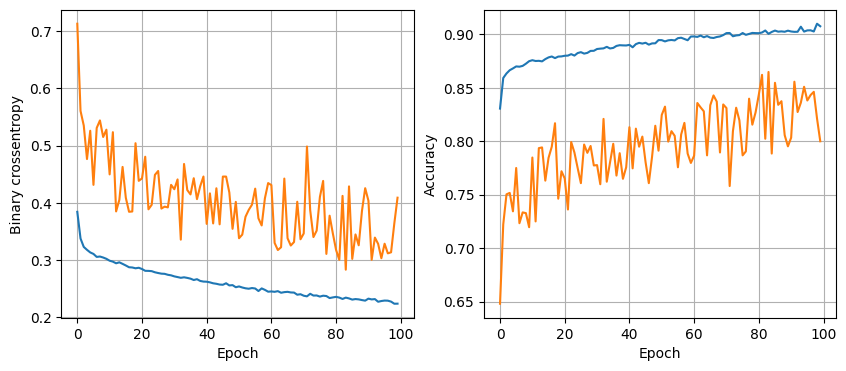

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.8559 - loss: 0.3847
100 epochs, 32 nodes, 0 dropout, 0.005 lr, 64 batch size


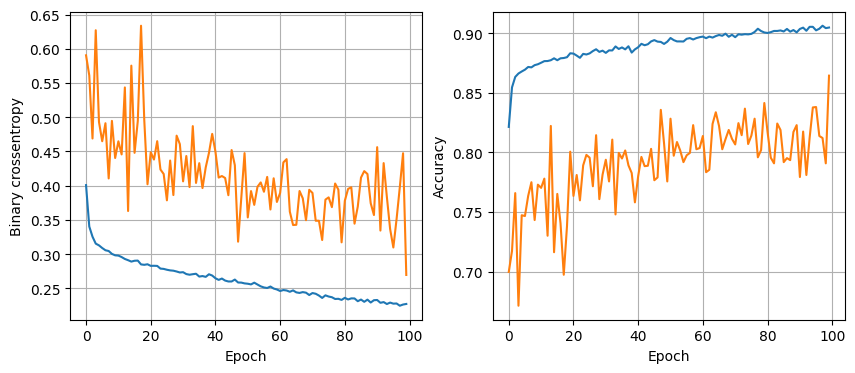

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.8437 - loss: 0.4082
100 epochs, 32 nodes, 0 dropout, 0.005 lr, 128 batch size


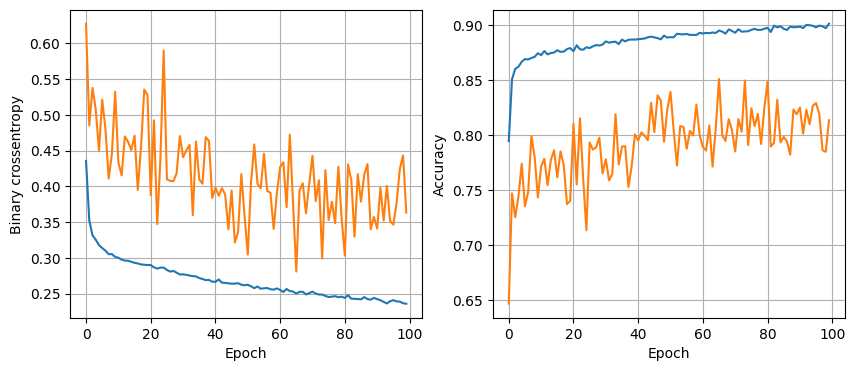

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.8518 - loss: 0.3581
100 epochs, 32 nodes, 0 dropout, 0.001 lr, 32 batch size


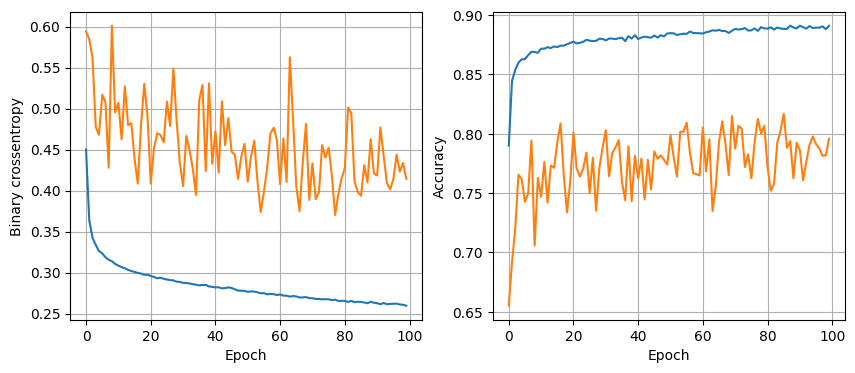

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.8577 - loss: 0.3452
100 epochs, 32 nodes, 0 dropout, 0.001 lr, 64 batch size


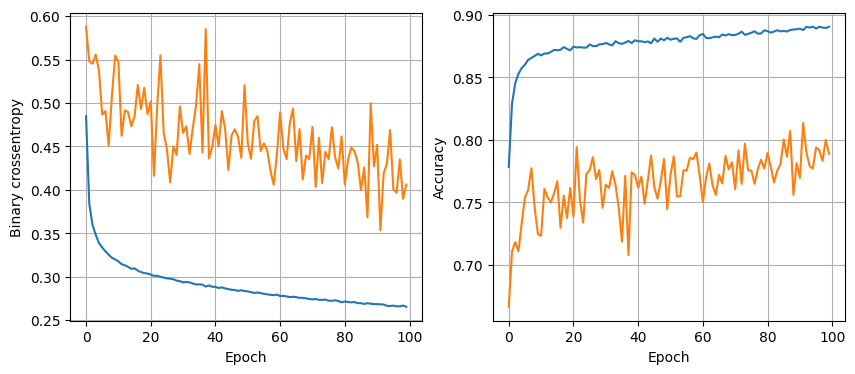

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.8556 - loss: 0.3392
100 epochs, 32 nodes, 0 dropout, 0.001 lr, 128 batch size


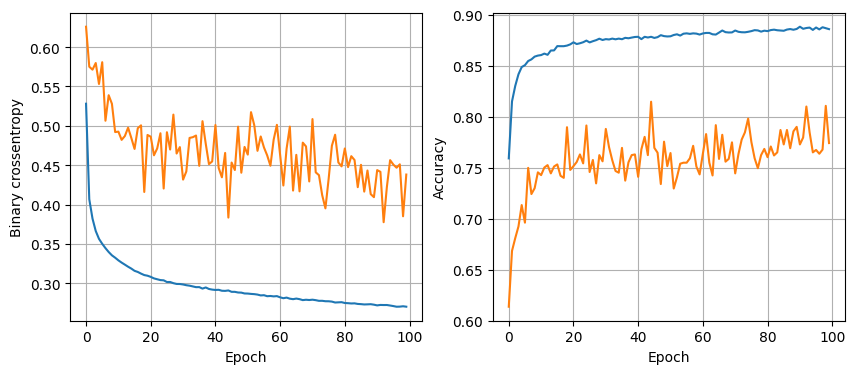

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.8572 - loss: 0.3357
100 epochs, 32 nodes, 0.2 dropout, 0.1 lr, 32 batch size


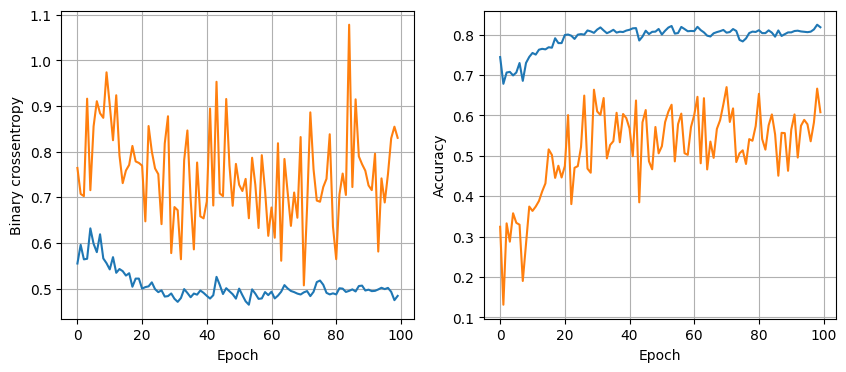

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.8338 - loss: 0.4566
100 epochs, 32 nodes, 0.2 dropout, 0.1 lr, 64 batch size


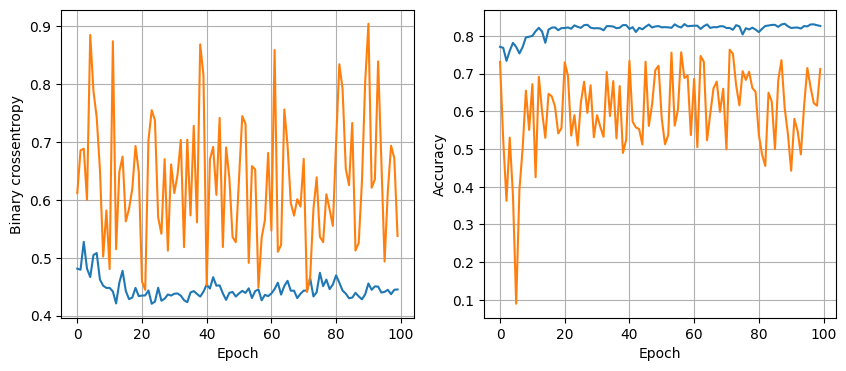

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.8462 - loss: 0.4097
100 epochs, 32 nodes, 0.2 dropout, 0.1 lr, 128 batch size


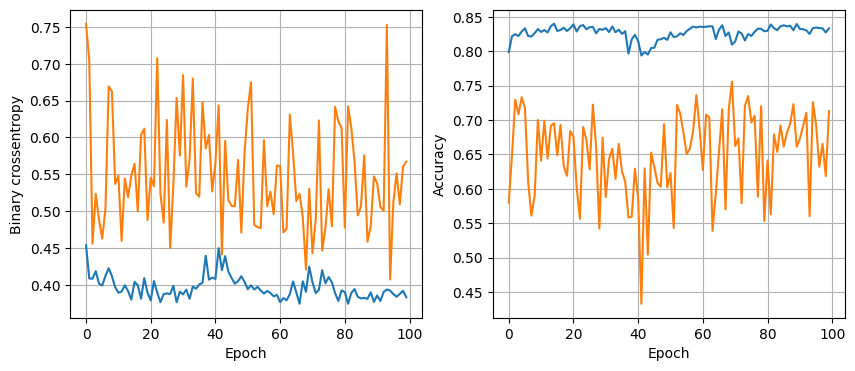

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.8507 - loss: 0.3990
100 epochs, 32 nodes, 0.2 dropout, 0.005 lr, 32 batch size


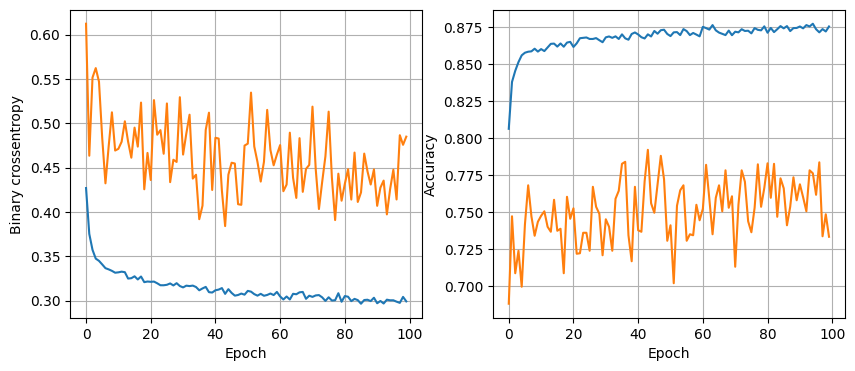

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8568 - loss: 0.3267
100 epochs, 32 nodes, 0.2 dropout, 0.005 lr, 64 batch size


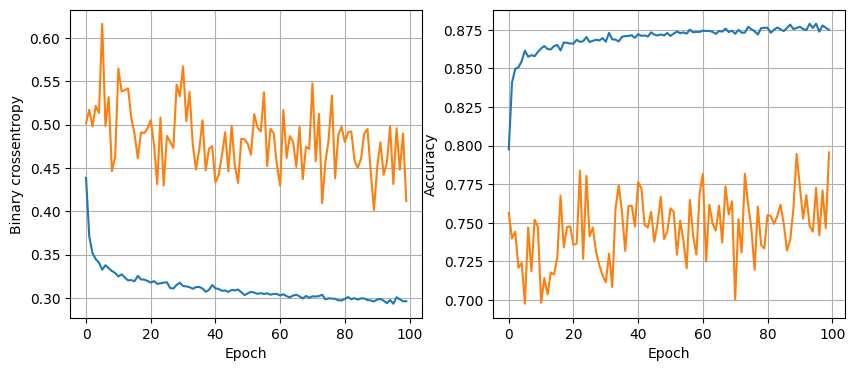

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8610 - loss: 0.3246
100 epochs, 32 nodes, 0.2 dropout, 0.005 lr, 128 batch size


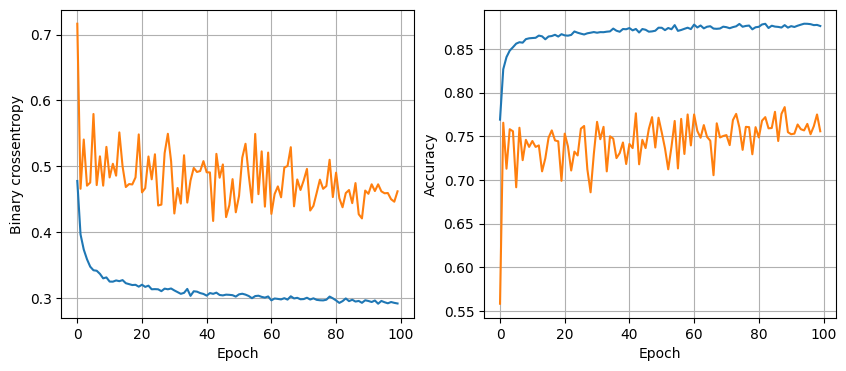

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.8615 - loss: 0.3189
100 epochs, 32 nodes, 0.2 dropout, 0.001 lr, 32 batch size


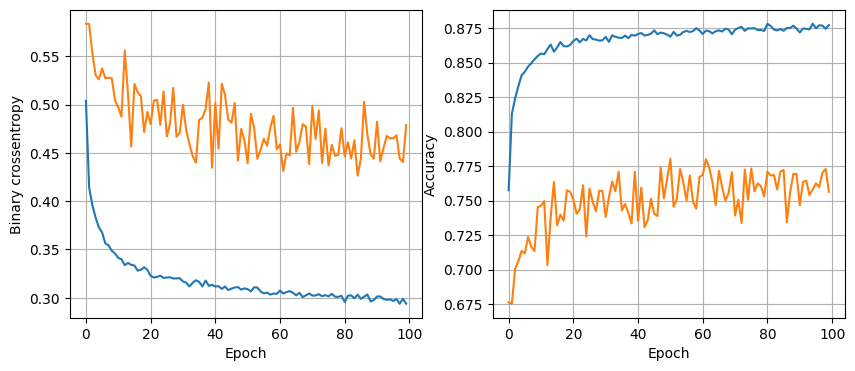

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.8581 - loss: 0.3251
100 epochs, 32 nodes, 0.2 dropout, 0.001 lr, 64 batch size


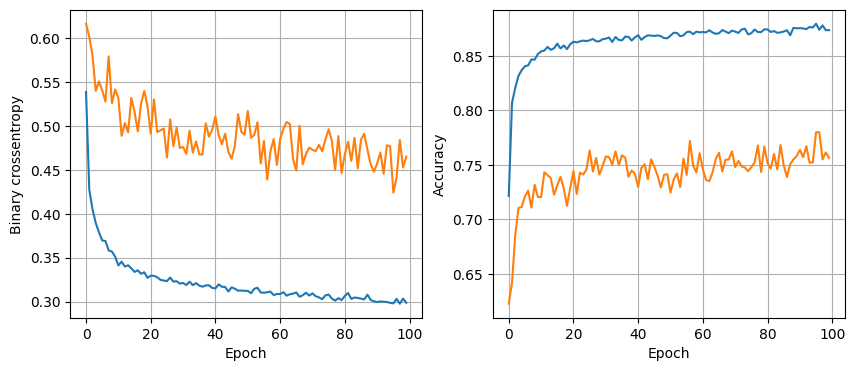

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.8584 - loss: 0.3188
100 epochs, 32 nodes, 0.2 dropout, 0.001 lr, 128 batch size


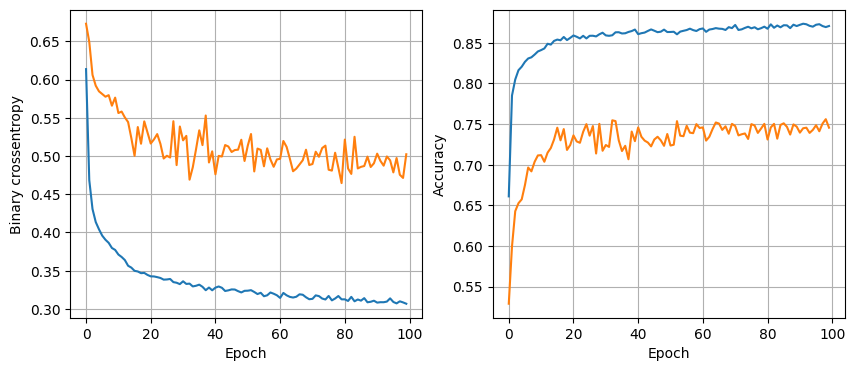

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.8634 - loss: 0.3226
100 epochs, 64 nodes, 0 dropout, 0.1 lr, 32 batch size


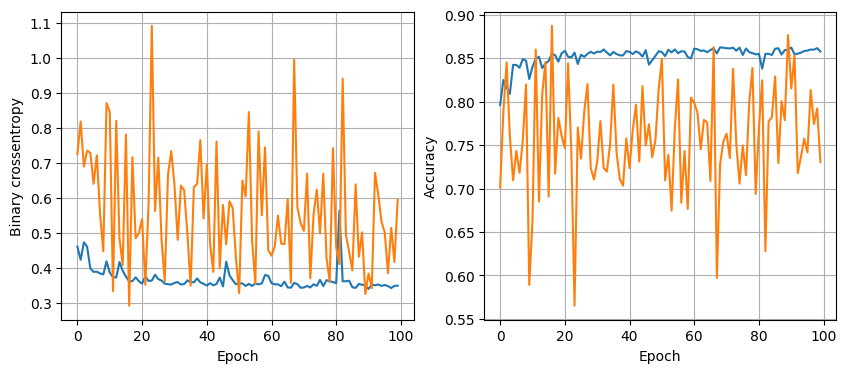

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.8436 - loss: 0.4006
100 epochs, 64 nodes, 0 dropout, 0.1 lr, 64 batch size


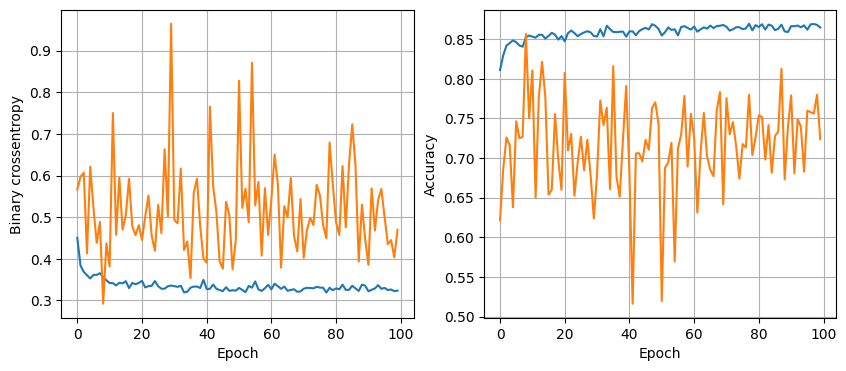

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.8565 - loss: 0.3522
100 epochs, 64 nodes, 0 dropout, 0.1 lr, 128 batch size


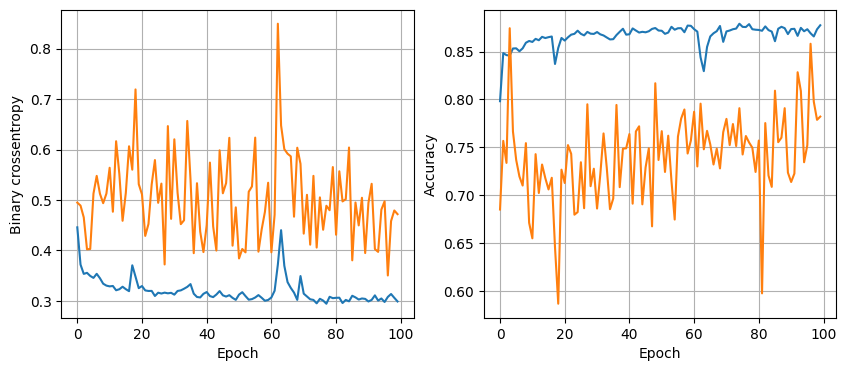

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.8509 - loss: 0.3528
100 epochs, 64 nodes, 0 dropout, 0.005 lr, 32 batch size


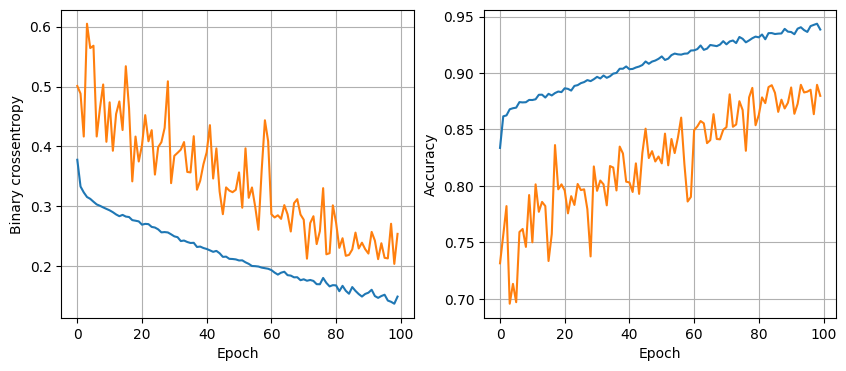

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.8452 - loss: 0.6499
100 epochs, 64 nodes, 0 dropout, 0.005 lr, 64 batch size


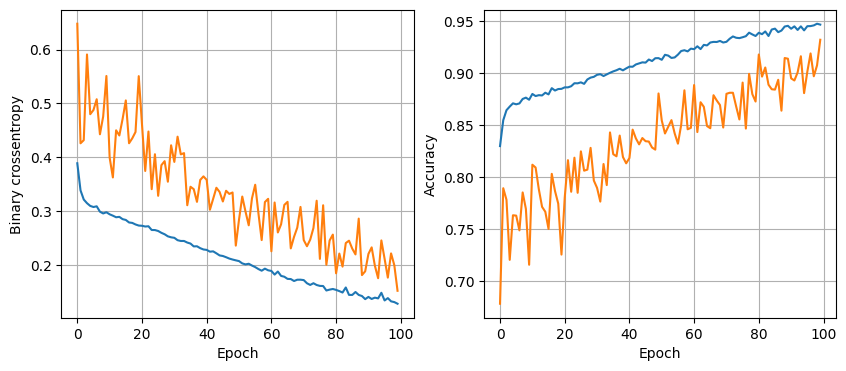

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.8439 - loss: 0.6222
100 epochs, 64 nodes, 0 dropout, 0.005 lr, 128 batch size


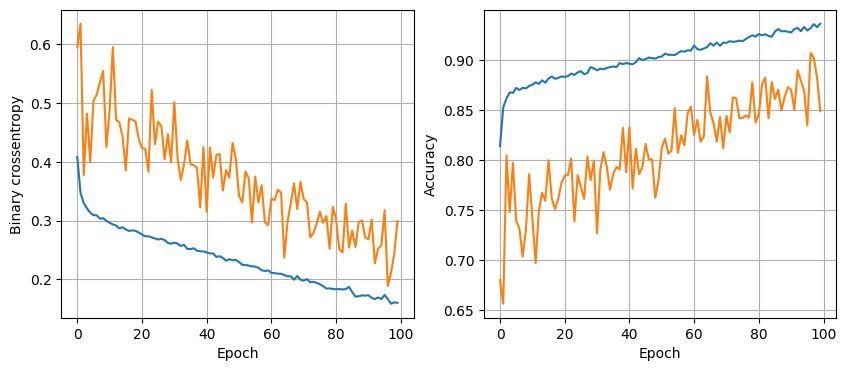

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - accuracy: 0.8536 - loss: 0.5061
100 epochs, 64 nodes, 0 dropout, 0.001 lr, 32 batch size


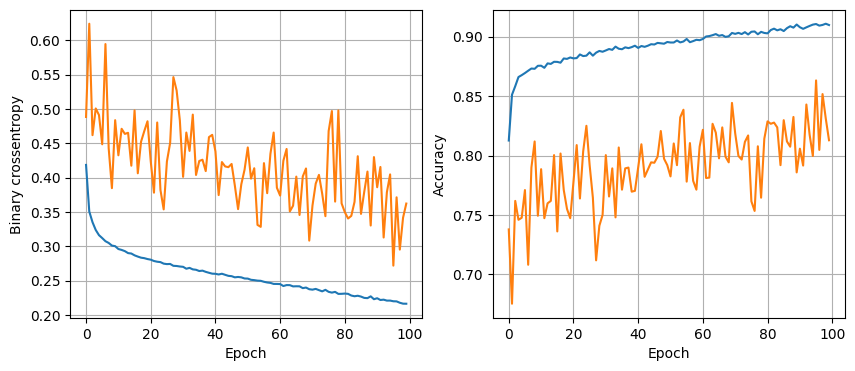

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.8591 - loss: 0.3544
100 epochs, 64 nodes, 0 dropout, 0.001 lr, 64 batch size


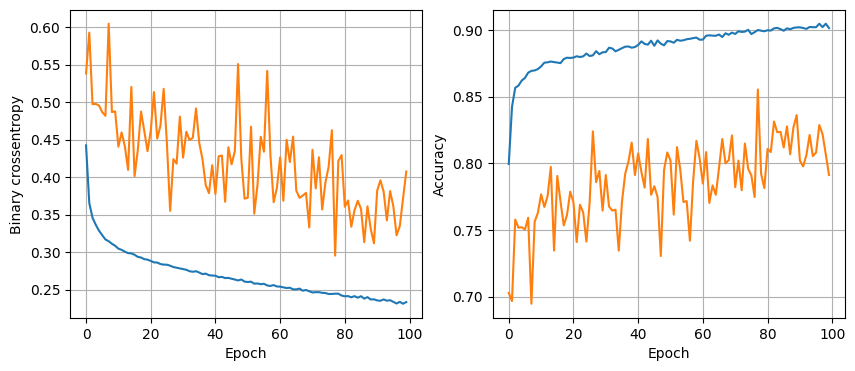

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.8627 - loss: 0.3306
100 epochs, 64 nodes, 0 dropout, 0.001 lr, 128 batch size


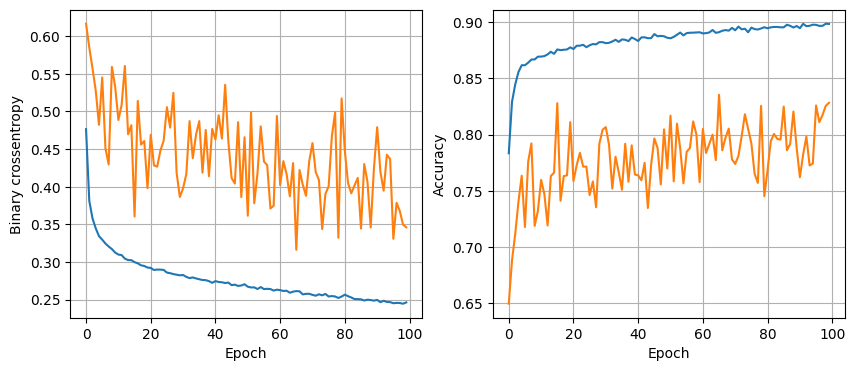

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.8509 - loss: 0.3436
100 epochs, 64 nodes, 0.2 dropout, 0.1 lr, 32 batch size


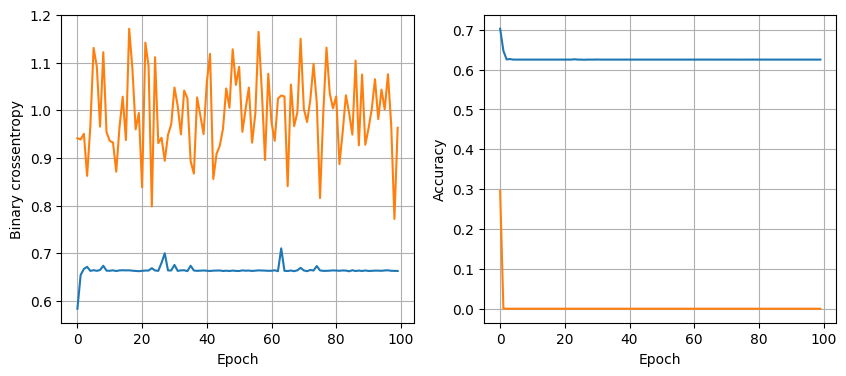

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.6544 - loss: 0.6475
100 epochs, 64 nodes, 0.2 dropout, 0.1 lr, 64 batch size


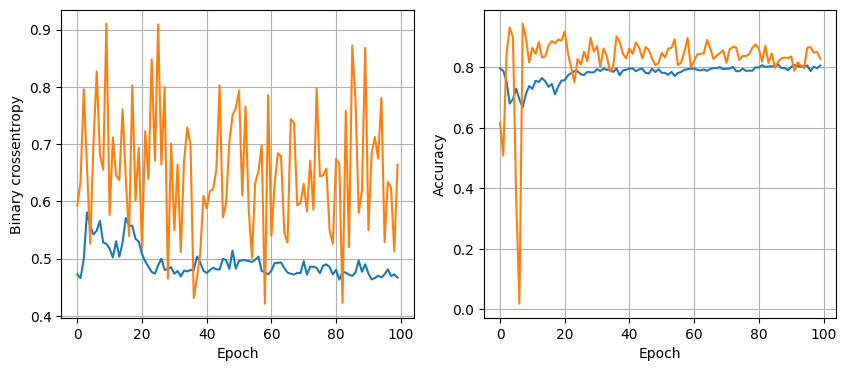

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.8103 - loss: 0.4624
100 epochs, 64 nodes, 0.2 dropout, 0.1 lr, 128 batch size


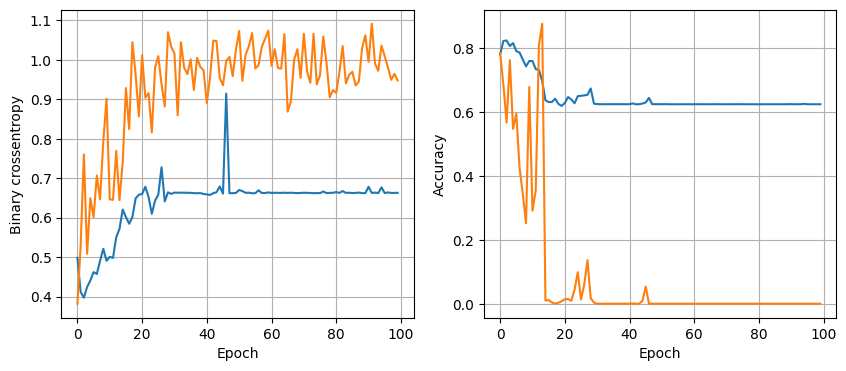

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6544 - loss: 0.6485
100 epochs, 64 nodes, 0.2 dropout, 0.005 lr, 32 batch size


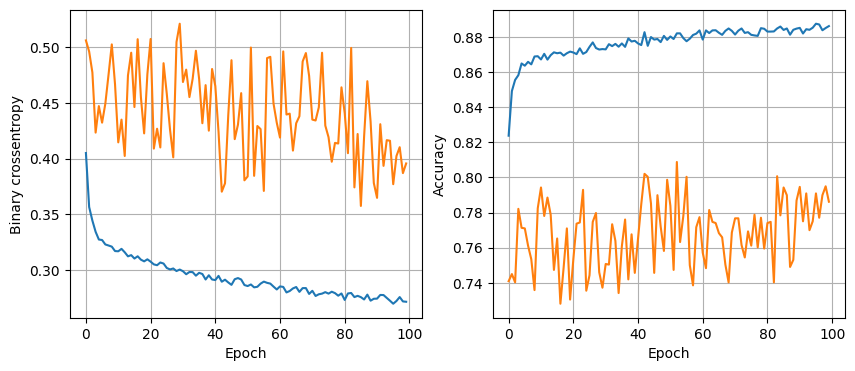

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.8742 - loss: 0.3133
100 epochs, 64 nodes, 0.2 dropout, 0.005 lr, 64 batch size


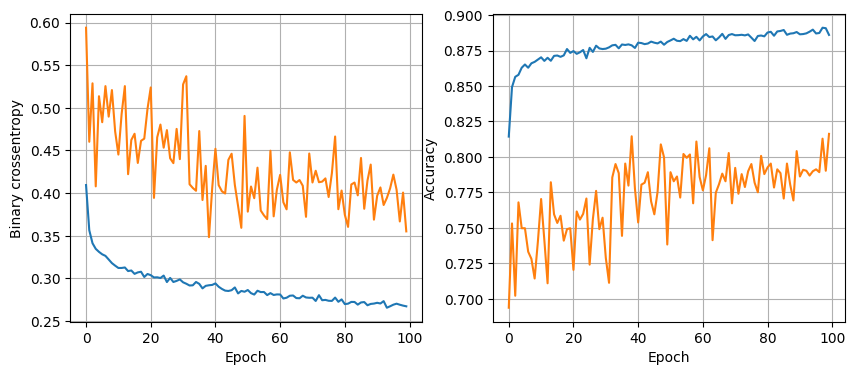

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.8627 - loss: 0.3210
100 epochs, 64 nodes, 0.2 dropout, 0.005 lr, 128 batch size


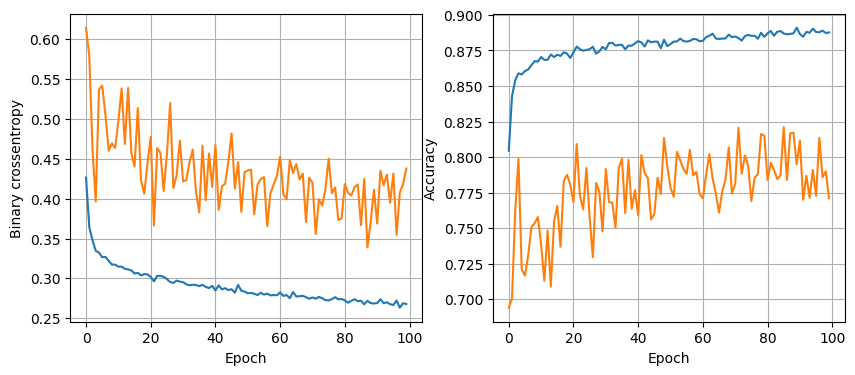

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.8715 - loss: 0.3216
100 epochs, 64 nodes, 0.2 dropout, 0.001 lr, 32 batch size


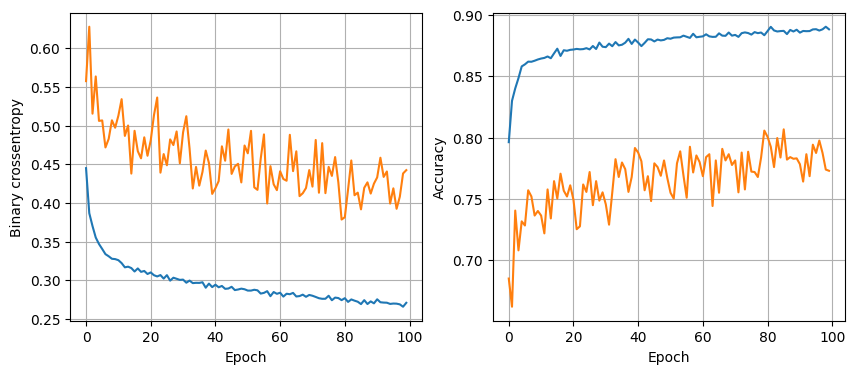

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.8701 - loss: 0.3154
100 epochs, 64 nodes, 0.2 dropout, 0.001 lr, 64 batch size


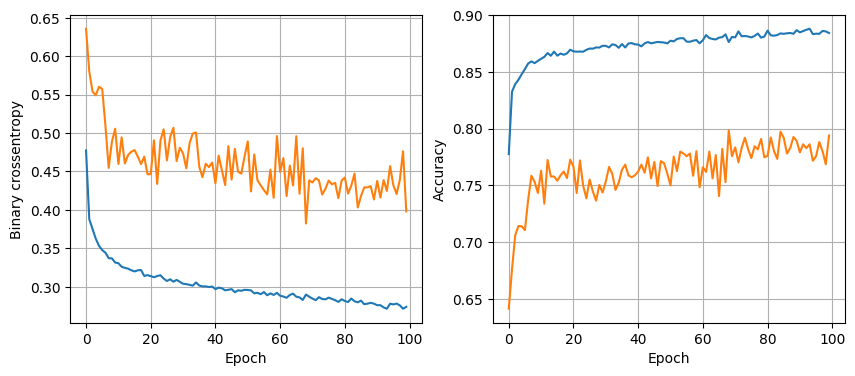

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.8651 - loss: 0.3143
100 epochs, 64 nodes, 0.2 dropout, 0.001 lr, 128 batch size


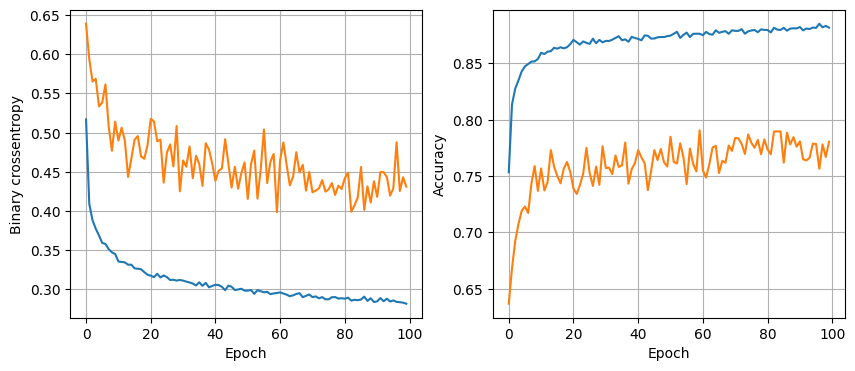

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.8616 - loss: 0.3171


In [27]:
least_val_loss = float("inf")
least_loss_model = None

epochs = 100

for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.1, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{epochs} epochs, {num_nodes} nodes, {dropout_prob} dropout, {lr} lr, {batch_size} batch size")
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs, 0)
                plot_history(history)
                val_loss, val_acc = model.evaluate(X_valid, y_valid)
                

                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [29]:
# Predict
# Notice that some values are really close to 1 and some are really close to 0, this is because it is a signmoid output
y_pred = least_loss_model.predict(X_test)
print(y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
[[0.98308426]
 [0.01526701]
 [0.99297106]
 ...
 [0.97578686]
 [0.99889445]
 [0.99947804]]


In [32]:
# Classify everything above 0.5 as 1 and everything below 0.5 as 0
# Also reshape it into a column
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(y_pred)

[1 0 1 ... 1 1 1]


Note: it appears that the NN and SVM are pretty similar with NN having slightly better results

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1321
           1       0.89      0.94      0.91      2483

    accuracy                           0.88      3804
   macro avg       0.88      0.86      0.86      3804
weighted avg       0.88      0.88      0.88      3804

